In [32]:
# Instalasi library yang diperlukan (jalankan sekali jika belum ada)
#!pip install yfinance keras-tuner ta --quiet

import os
import random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime
from ta.momentum import RSIIndicator
from ta.trend import MACD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import pandas_datareader.data as web

# Set seed untuk reproducibility:contentReference[oaicite:3]{index=3}
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [33]:

# Ambil Fed Funds Rate dari FRED
fed_rate = web.DataReader('FEDFUNDS', 'fred', start='2020-01-01')
fed_rate.rename(columns={'FEDFUNDS': 'FedFundsRate'}, inplace=True)

# Daftar ticker Yahoo Finance
tickers = [
    "^JKSE", "^GSPC", "BZ=F", "GC=F", "SI=F",
    "NG=F", "HG=F", "^GDAXI", "GBPUSD=X",
    "EURUSD=X", "USDIDR=X", 
]

# Periode data (misal 2010 hingga hari ini)
start_date = "2010-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

# Unduh data harga dengan yfinance
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Ekstrak harga penutupan (Close) dan hapus kolom lainnya
if ('Close' in data.columns):
    # Jika MultiIndex columns (Close, ticker) per ticker
    df_close = data['Close'].copy()
else:
    # Jika single ticker
    df_close = data[['Close']].copy()
    
# Ubah nama kolom (jika perlu)
df_close.columns = [col if isinstance(col, str) else col[1] for col in df_close.columns]
df_close.index.name = 'Date'
df_close.head(3)


,BZ=F,EURUSD=X,GBPUSD=X,GC=F,HG=F,NG=F,SI=F,USDIDR=X,^GDAXI,^GSPC,^JKSE
Date,,,,,,,,,,,
2010-01-01,NaN,1.438994,1.613294,NaN,NaN,NaN,NaN,9385.599609,NaN,NaN,NaN
2010-01-04,80.120003,1.442398,1.611370,1117.699951,3.388,5.884,17.440001,9364.200195,6048.299805,1132.98999,2575.312988
2010-01-05,80.589996,1.436596,1.599079,1118.099976,3.396,5.637,17.781000,9305.200195,6031.859863,1136.52002,2605.175537


In [34]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd

# Ambil Fed Funds Rate dari FRED
fed_rate = web.DataReader('FEDFUNDS', 'fred', start='2020-01-01')
fed_rate.rename(columns={'FEDFUNDS': 'FedFundsRate'}, inplace=True)

# Daftar ticker Yahoo Finance
tickers = [
    "^JKSE", "^GSPC", "BZ=F", "GC=F", "SI=F",
    "NG=F", "HG=F", "^GDAXI", "GBPUSD=X",
    "EURUSD=X", "USDIDR=X",
]

# Periode data (misal 2010 hingga hari ini)
start_date = "2010-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

# Unduh data harga dengan yfinance
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Ekstrak harga penutupan (Close) dan hapus kolom lainnya
if 'Close' in data.columns:
    df_close = data['Close'].copy()
else:
    df_close = data[['Close']].copy()

# Ubah nama kolom (jika perlu)
df_close.columns = [col if isinstance(col, str) else col[1] for col in df_close.columns]
df_close.index.name = 'Date'

# Simpan ke CSV
df_close.to_csv('harga_penutupan.csv')
fed_rate.to_csv('fed_funds_rate.csv')

# Simpan ke Excel (dalam satu file, dua sheet)
with pd.ExcelWriter('data_keuangan.xlsx') as writer:
    df_close.to_excel(writer, sheet_name='Harga Penutupan')
    fed_rate.to_excel(writer, sheet_name='Fed Funds Rate')

print("Data berhasil disimpan dalam format CSV dan Excel.")


Data berhasil disimpan dalam format CSV dan Excel.


In [36]:
# Fokus pada data IHSG (IDX Composite)
ihsg = df_close['^JKSE'].to_frame(name='IHSG').copy()
ihsg = ihsg.dropna()  # hapus tanggal tanpa data IHSG


# MA10: Simple Moving Average 10 hari
ihsg['MA10'] = ihsg['IHSG'].rolling(window=10).mean()


# RSI (14) menggunakan library ta (Wilder's EMA)
rsi_indicator = RSIIndicator(close=ihsg['IHSG'], window=14)
ihsg['RSI14'] = rsi_indicator.rsi()


# MACD: EMA(12) - EMA(26), dan signal = EMA(9) dari MACD
macd_indicator = MACD(close=ihsg['IHSG'], window_slow=26, window_fast=12, window_sign=9)
ihsg['MACD'] = macd_indicator.macd()
ihsg['MACD_Signal'] = macd_indicator.macd_signal()


# Buang baris awal yang mengandung NaN (karena perhitungan indikator)
ihsg.dropna(inplace=True)
ihsg.head(3)

,IHSG,MA10,RSI14,MACD,MACD_Signal
Date,,,,,
2010-02-18,2559.934326,2522.571289,49.178608,-15.265432,-20.630275
2010-02-19,2554.276367,2526.111108,48.210150,-13.673629,-19.238946
2010-02-22,2564.163330,2534.979883,50.060840,-11.481961,-17.687549


In [37]:
# Gabungkan data indikator global (Close) dengan IHSG
df_all = ihsg.join(df_close.drop(columns=['^JKSE']), how='inner')

# Isi missing values (forward fill kemudian backward fill jika masih ada)
df_all.fillna(method='ffill', inplace=True)
df_all.fillna(method='bfill', inplace=True)

# Gabungkan dengan data lain berdasarkan tanggal
df_all = df_all.join(fed_rate, how='left')
df_all.fillna(method='ffill', inplace=True)  # Imputasi forward fill
df_all.fillna(method='bfill', inplace=True)

# Simpan kolom target (IHSG)
target = df_all['IHSG'].values.reshape(-1, 1)

df_all.dropna(inplace=True)

# then continue with:
target = df_all['IHSG'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_all)
scaled_df = pd.DataFrame(scaled_data, index=df_all.index, columns=df_all.columns)

scaled_df.head(3)


,IHSG,MA10,RSI14,MACD,MACD_Signal,BZ=F,EURUSD=X,GBPUSD=X,GC=F,HG=F,NG=F,SI=F,USDIDR=X,^GDAXI,^GSPC,FedFundsRate
Date,,,,,,,,,,,,,,,,
2010-02-18,0.008516,0.000000,0.505479,0.699857,0.658783,0.537966,0.736545,0.729870,0.028467,0.410652,0.450110,0.117371,0.532777,0.031920,0.016434,0.0
2010-02-19,0.007467,0.000671,0.491929,0.702311,0.661288,0.541740,0.765812,0.736246,0.029865,0.432626,0.434496,0.126951,0.519933,0.034106,0.016907,0.0
2010-02-22,0.009300,0.002351,0.517823,0.705691,0.664081,0.545605,0.764012,0.739745,0.026180,0.417213,0.416321,0.121767,0.519284,0.032342,0.016680,0.0


In [38]:
def create_sequences(data, target_column, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_x = data[i:(i + seq_length)].values
        seq_y = data[target_column].iloc[i + seq_length]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_df, 'IHSG', sequence_length)

print(f"Shape X: {X.shape}, shape y: {y.shape}")


Shape X: (3642, 60, 16), shape y: (3642,)


In [39]:
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 2913, Testing samples: 729


In [40]:
def build_lstm_model(hp):
    try:
        model = keras.Sequential()
        # Layer LSTM pertama
        model.add(keras.layers.LSTM(
            units=hp.Int('units1', min_value=50, max_value=200, step=50),
            return_sequences=True,
            input_shape=(sequence_length, X_train.shape[2])
        ))
        model.add(keras.layers.Dropout(
            rate=hp.Float('dropout1', 0.1, 0.5, step=0.1)
        ))
        # Layer LSTM kedua
        model.add(keras.layers.LSTM(
            units=hp.Int('units2', min_value=50, max_value=200, step=50)
        ))
        model.add(keras.layers.Dropout(
            rate=hp.Float('dropout2', 0.1, 0.5, step=0.1)
        ))
        # Output layer
        model.add(keras.layers.Dense(1))
        # Compile
        model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=hp.Choice('lr', [1e-3, 1e-4, 1e-5])
            ),
            loss='mean_squared_error'
        )
        return model

    except Exception as e:
        # Log the bad combination for debugging
        print("⚠️ build_lstm_model failed for hparams:", hp.values)
        print("   Error:", e)
        return None  # signals a failed trial to the tuner

In [41]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='ihsg_prediksi',
    max_consecutive_failed_trials=20
)

tuner.search_space_summary()

# Jalankan pencarian dengan data latih dan validasi
tuner.search(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
)

# Tampilkan hasil terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("HP terbaik:")
print(f"Units1: {best_hps.get('units1')}, Dropout1: {best_hps.get('dropout1')}")
print(f"Units2: {best_hps.get('units2')}, Dropout2: {best_hps.get('dropout2')}")
print(f"Learning rate: {best_hps.get('lr')}")


Trial 10 Complete [00h 02m 38s]
val_loss: 0.002107229782268405

Best val_loss So Far: 0.0007496179896406829
Total elapsed time: 00h 36m 23s
HP terbaik:
Units1: 200, Dropout1: 0.2
Units2: 150, Dropout2: 0.1
Learning rate: 0.001


In [42]:
# Bangun model dengan parameter terbaik
best_model = tuner.hypermodel.build(best_hps)

# Latih model menggunakan seluruh data latih
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Prediksi pada data uji
y_pred = best_model.predict(X_test).flatten()

# Hitung RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

# Hitung SMAPE
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape = SMAPE(y_test, y_pred)
print(f"Test SMAPE: {smape:.2f}%")


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - loss: 0.0262 - val_loss: 4.4292e-04
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - loss: 0.0012 - val_loss: 6.0601e-04
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - loss: 0.0011 - val_loss: 2.8936e-04
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - loss: 8.3857e-04 - val_loss: 8.6175e-04
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - loss: 0.0011 - val_loss: 2.2649e-04
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - loss: 7.8671e-04 - val_loss: 6.4657e-04
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - loss: 8.7019e-04 - val_loss: 2.1916e-04
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - loss: 7.4170e-04 - val_loss: 2.3223e-04
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - loss: 7.5125e-04 - val_loss: 6.3745e-04
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - loss: 8.2423e-04 - val_loss: 3.8629e-04
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step 

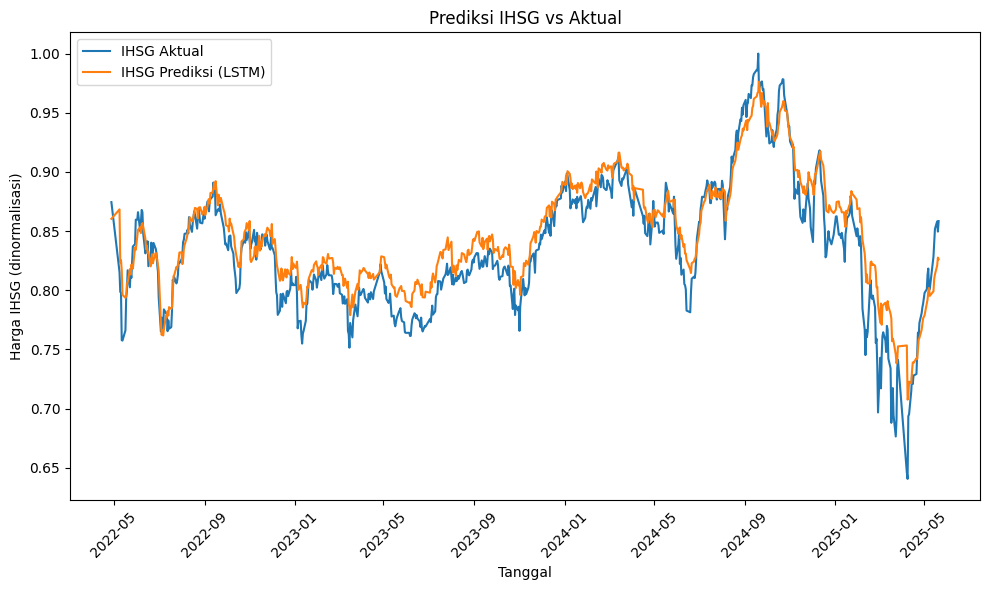

Test RMSE: 0.0208
Test SMAPE: 2.00%


In [43]:
# Data tanggal untuk rentang pengujian
dates = scaled_df.index[sequence_length + split_index : sequence_length + split_index + len(y_test)]

plt.figure(figsize=(10,6))
plt.plot(dates, y_test, label='IHSG Aktual')
plt.plot(dates, y_pred, label='IHSG Prediksi (LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Harga IHSG (dinormalisasi)')
plt.title('Prediksi IHSG vs Aktual')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f"Test RMSE: {rmse:.4f}")
print(f"Test SMAPE: {smape:.2f}%")

